# Anton Marin

Some imports first

In [2]:
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import math
from tqdm import tqdm
%matplotlib inline

Degrees to radians

In [3]:
def deg_to_rad(deg):
    return math.pi*deg/180

Loading data

In [4]:
matA = (loadmat('data/20071207_A_Dif_0435_0415.mat')['data'])
matB = (loadmat('data/20071207_B_Dif_0435_0415.mat')['data'])

Defining helping functions and Stereo's positions

In [5]:
class Stereo:    
    @classmethod
    def dist_top(cls):
        return cls.C[1] - cls.rad
    
    @classmethod
    def rad_parallel_cut(cls):
        out = np.zeros(2*cls.rad+1)
        for it in range(2*cls.rad+1):
            out[it]=(((cls.rad**2-(cls.rad-it)**2))**0.5)
        return out

    @classmethod
    def nanleft(cls):
        return cls.C[0] - cls.rad_parallel_cut()
    
    @classmethod
    def coord_pixel_to_real(cls, pixel):
        i = pixel[0]
        j = pixel[1]
        R = Global.R_km
        Y=(j-cls.nanleft()[i-cls.dist_top()]-cls.rad_parallel_cut()[i-cls.dist_top()])*(R/cls.rad) #  %Axis OY is directed to the right (j - change of columns)
        Z=(-(i-cls.rad-cls.dist_top()))*(R/cls.rad) #           %Axis OZ is directed to the top   (i - change of rows)
        X=(R**2-Y**2-Z**2)**0.5 #        
        return (X, Y, Z)
    
    @classmethod
    def coord_real_to_pixel(cls, point):
        Y, Z = point[1], point[2]
        i=int(cls.rad+cls.dist_top()-(Z*(cls.rad/Global.R_km)))
        j=int(cls.nanleft()[i-cls.dist_top()]+cls.rad_parallel_cut()[i-cls.dist_top()]+Y*(cls.rad/Global.R_km))
        return (i,j)
    
    @classmethod 
    def HEEQ_to_point_sat(cls, point):
        X1, Y1, Z1 = point[0], point[1], point[2]
        X=math.cos(cls.Phi)*math.cos(cls.Theta)*X1+math.sin(cls.Phi)*math.cos(cls.Theta)*Y1+math.sin(cls.Theta)*Z1
        Y=-math.sin(cls.Phi)*X1+math.cos(cls.Phi)*Y1
        Z=-math.cos(cls.Phi)*math.sin(cls.Theta)*X1-math.sin(cls.Phi)*math.sin(cls.Theta)*Y1+math.cos(cls.Theta)*Z1
        return (X, Y, Z)

    @classmethod
    def point_sat_to_HEEQ(cls, point):
        X1, Y1, Z1 = point[0], point[1], point[2]
        X=math.cos(cls.Phi)*math.cos(cls.Theta)*X1-math.sin(cls.Phi)*Y1-math.cos(cls.Phi)*math.sin(cls.Theta)*Z1
        Y=math.sin(cls.Phi)*math.cos(cls.Theta)*X1+math.cos(cls.Phi)*Y1-math.sin(cls.Theta)*math.sin(cls.Phi)*Z1
        Z=math.sin(cls.Theta)*X1+math.cos(cls.Theta)*Z1
        return (X, Y, Z)
    
class StereoA(Stereo):
    rad = 630
    C = (700, 700)
    Phi = deg_to_rad(20.62)
    Theta = deg_to_rad(-2.535)
    Dist = 0.966587
    
class StereoB(Stereo):
    rad = 593
    C = (700, 700)
    Phi = deg_to_rad(-21.424)
    Theta = deg_to_rad(3.089)
    Dist = 1.026675
    
class Global:
    R_km = 701407
    AU = 149597870.691

Solving line AC and sphere intersection equation

In [75]:
def solve(A, C, R):
    """
    Input: A - position of StereoA in StereoA coordinates, C - position of C in StereoA coordinates
    designations are from the lecture, if 
    """
    Xc = C[0] - A[0]
    Yc = C[1] - A[1]
    Zc = C[2] - A[1]
    def get_solution(y):
        x = A[0]+Xc/Yc*(y-A[1])
        z = A[2]+Zc/Yc*(y-A[1])
        return (x,y,z)
    A_s = Xc**2/Yc**2 + Zc**2/Yc**2+1
    B_s = 2*(A[0]*Xc/Yc-Xc**2/Yc**2*A[1]+A[2]*Zc/Yc-Zc**2/Yc**2*A[1])
    C_s = A[0]**2-2*A[0]*Xc/Yc*A[1]+Xc**2/Yc**2*A[1]**2+A[2]**2+2*A[2]*Zc/Yc*A[1]+Zc**2/Yc**2*A[1]**2-R**2
    
    D = B_s**2 - 4*A_s*C_s
    if D<0:
        return None
    y_1 = (-B_s - D**0.5)/(2*A_s)
    sol1 = get_solution(y_1)
    y_2 = (-B_s + D**0.5)/(2*A_s)
    sol2 = get_solution(y_2)
    
    assert abs(sol1[0]**2 + sol1[1]**2 + sol1[2]**2 - R**2)<1000
    assert abs((sol1[0]-A[0])/(C[0]-A[0])-(sol1[1]-A[1])/(C[1]-A[1]))<0.1
    assert abs((sol1[0]-A[0])/(C[0]-A[0])-(sol1[2]-A[2])/(C[2]-A[2]))<0.1
    assert abs(sol2[0]**2 + sol2[1]**2 + sol2[2]**2 - R**2)<1000
    assert abs((sol2[0]-A[0])/(C[0]-A[0]) - (sol2[1]-A[1])/(C[1]-A[1]))<0.1
    assert abs((sol2[0]-A[0])/(C[0]-A[0]) - (sol2[2]-A[2])/(C[2]-A[2]))<0.1
    # choosing point with greater X
    if sol1[0]>sol2[0]:
        return sol1
    else:
        return sol2

This is main function, in which all calculations are done. All designations are made in case that point N on StereoB's picture is selected first and then transformed to StereoA's picture. However, one can switch the order of Stereo's and their data in this function, because no global variables are used. 

In [63]:

def plot_epipolar(N_second_pixel, StereoA, StereoB, matA, matB, k_range=None, plot=True, inverted=False):
    title_1 = 'StereoA' if not inverted else 'StereoB'
    title_2 = 'StereoB' if not inverted else 'StereoA'
    
    choosen_point = 'N' if not inverted else 'M'
    other_point = 'M' if not inverted else 'N'
    epipolar_line = 'BN' if not inverted else 'AM'
        
        
    H=None
    B_B = (StereoB.Dist*Global.AU,0,0)
    N_B = StereoB.coord_pixel_to_real(N_second_pixel)
    A_A = (StereoA.Dist*Global.AU,0,0)

    point_vec = np.array(N_B) - np.array(B_B)

    N_A = StereoA.HEEQ_to_point_sat(StereoB.point_sat_to_HEEQ(N_B))
    B_A = StereoA.HEEQ_to_point_sat(StereoB.point_sat_to_HEEQ(B_B))

    N_A_pixel = StereoA.coord_real_to_pixel(N_A)

    C_x_A_pix = []
    C_y_A_pix = []
    
    C_A_M = None
    C_A_M_pixel = None
    
    #ensemble of C
    for k in range(520):
        C_B = [0,0,0]
        C_B[0] = N_B[0] + k * 1250
        C_B[1] = point_vec[1]/point_vec[0]*(C_B[0]-B_B[0]) + B_B[1]
        C_B[2] = point_vec[2]/point_vec[0]*(C_B[0]-B_B[0]) + B_B[2]

        C_heeq = StereoB.point_sat_to_HEEQ(C_B)
        C_A = StereoA.HEEQ_to_point_sat(C_heeq)
        C_A_pix = StereoA.coord_real_to_pixel(C_A)
        
        if k_range and k==k_range:
            C_A_M = C_A
            C_A_M_pixel = C_A_pix
            H = (C_heeq[0]**2 + C_heeq[1]**2 + C_heeq[2]**2)**0.5 - Global.R_km
            M_A = solve(A_A, C_A, Global.R_km)
            M_A_pixel = StereoA.coord_real_to_pixel(M_A)
        C_x_A_pix.append(C_A_pix[0])
        C_y_A_pix.append(C_A_pix[1])
#         M_B = StereoB.HEEQ_to_point_sat(StereoA.point_sat_to_HEEQ(M_A))
        
    #plotting
    if plot:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))
        ax1.imshow(matA, cmap=plt.get_cmap('inferno'), vmin=-30, vmax=50)
        ax1.plot(N_A_pixel[1], N_A_pixel[0], marker='o', color='y', label=choosen_point)
        ax1.plot(C_y_A_pix, C_x_A_pix, marker='.', ms=0.1, color='y', label=epipolar_line)
        if k_range:
            ax1.plot(M_A_pixel[1], M_A_pixel[0], marker='o', color='r', label=other_point)
        ax1.set_title(title_1)
        ax1.legend()

        ax2.imshow(matB, cmap=plt.get_cmap('inferno'), vmin=-30, vmax=50)
        ax2.plot(N_second_pixel[1], N_second_pixel[0], marker='o', color='#FFEEEE', label=choosen_point)
        ax2.legend()
        ax2.set_title(title_2)
    if k_range:
        return H

First I fix point $N\_B\_pixel$ from StereoB. Then I plot line $BN$ in StereoA.
By selecting $k$, s. t. line $AC$ tangents wave front, I find $C$ and $H$ - height of wave

### Northern crest

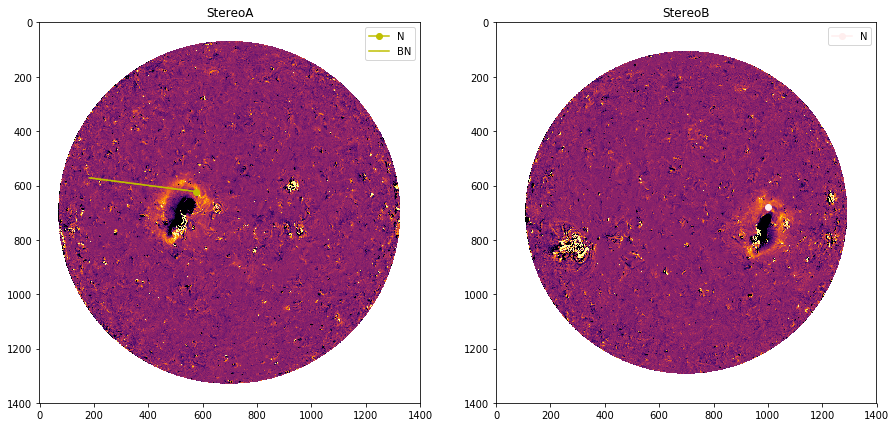

In [85]:
N_B_pixel = (680, 1000)
plot_epipolar(N_B_pixel, StereoA, StereoB, matA, matB)

Approximate height of wave at the Northern wave crest $\approx 132285$ km

126971.29508201219

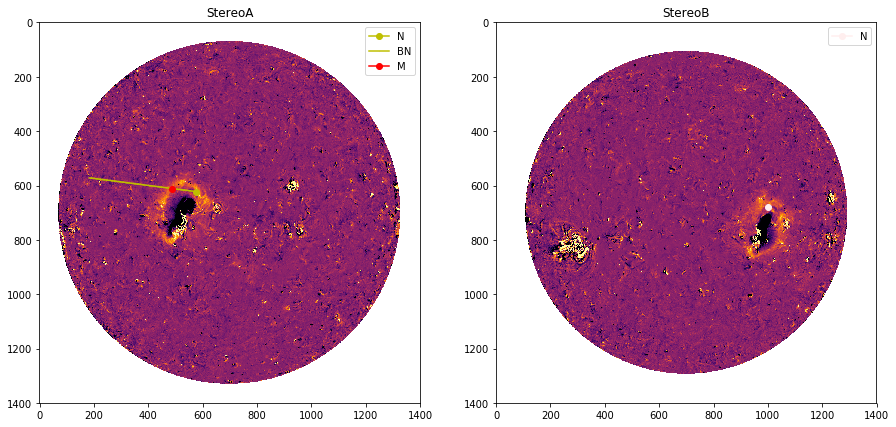

In [86]:
plot_epipolar(N_B_pixel, StereoA, StereoB, matA, matB, k_range=115,)

### Western crest

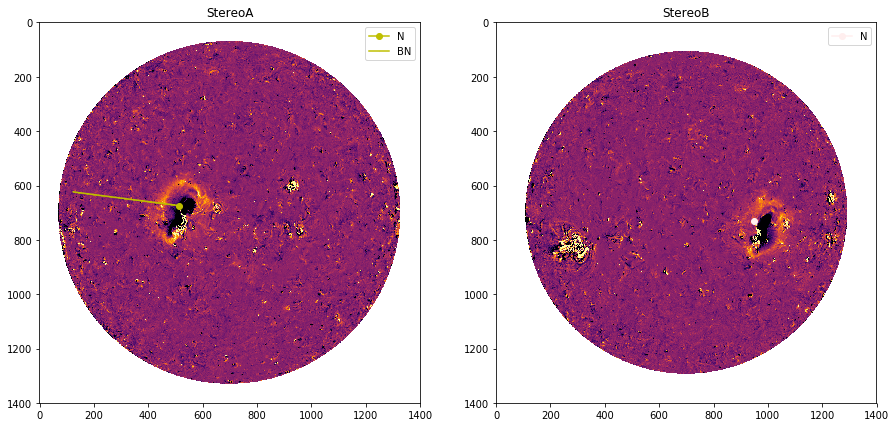

In [69]:
N_B_pixel = (730, 950)
plot_epipolar(N_B_pixel, StereoA, StereoB, matA, matB)


Approximate height of wave at the Western wave crest $\approx 103193$ km

103192.90923594392

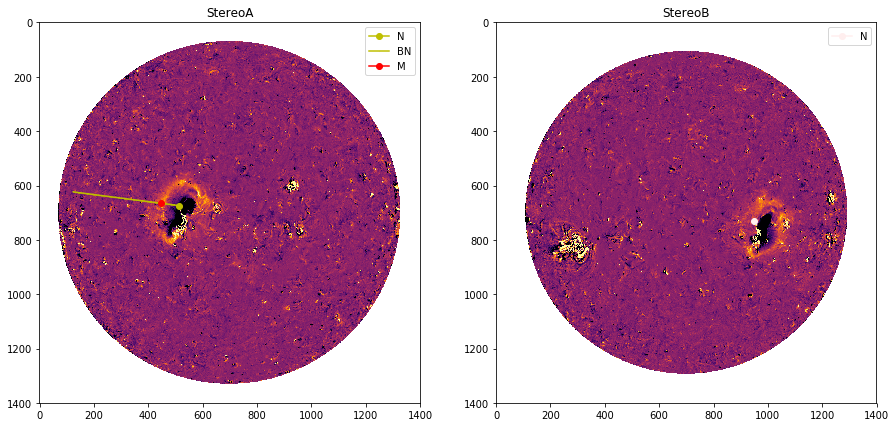

In [77]:
plot_epipolar(N_B_pixel, StereoA, StereoB, matA, matB, k_range=90)

### Eastern crest

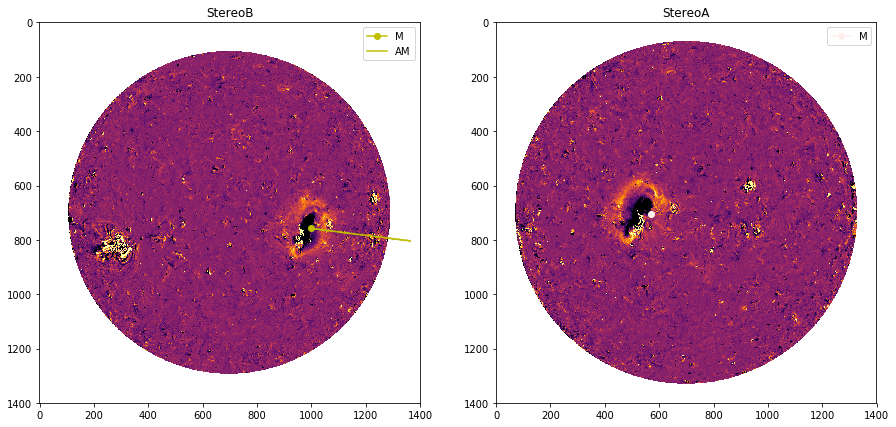

In [82]:
N_A_pixel = (705, 570)
plot_epipolar(N_A_pixel, StereoB, StereoA, matB, matA, inverted=True)

Approximate height of wave at the Eastern wave crest $\approx 110387$ km

110387.47826438467

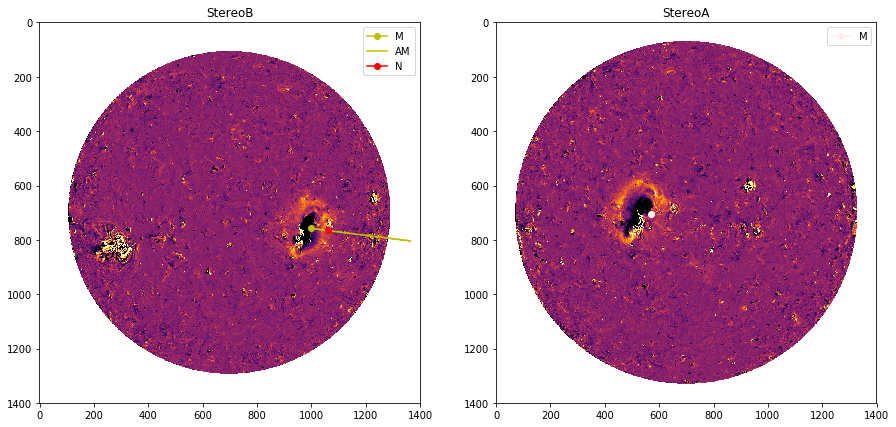

In [84]:
plot_epipolar(N_A_pixel, StereoB, StereoA, matB, matA, k_range=90, inverted=True)